In [1]:
# Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

SVM is a powerful model, capable of performing:
- Linear or nonlinear classification
- Regression
- Outlier detection

Well suited for classification of complex small or medium datasets.

## Linear SVM Classification

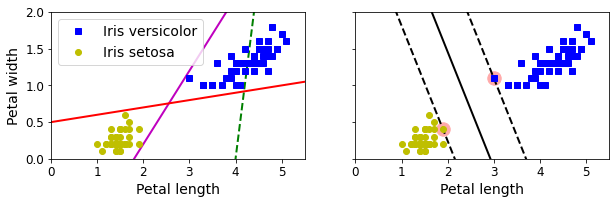

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

The left figure shows 3 possible linear classifier. We can see that the dashed line couldn't separate groups. The purple and red lines were able to separate the groups, however their boundaries are too close to the instances. It will probably not perform well on new instances.

The right figure shows a SVM classifier. The solid line divide the groups, while the dashed lines mark the support vectors. It looks like a road, and the widest, the better. We can see that the groups are much more separated, which will perform better when we add new instances.<br>
Note: SVM is sensible to feature scales, so we should scale our features when planning to use SVM and it will perform better.

### Soft Margin Classification

Sometimes we can't separate the groups completely (some outlier might be mixed in the other group), and if we try to separate it anyway, we might end up it a narrow "road", that won't perform good on new instances because it will overfit the training data.

On the other hand, if we give in too much in order to "strech the road" and avoid overfitting, we might end up with a model that can't distinguish between the groups.

In these cases, we need to find a sweet spot by tuning the hyperparameter C.

In [3]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris virginica
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

## Nonlinear SVM Classification

Some datasets can't be separated by a straigh line.

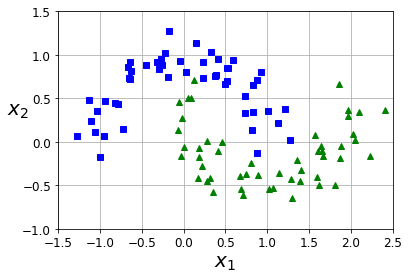

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15)
polynomial_svm_clf = Pipeline([('poly_features', PolynomialFeatures(degree = 3)),
                               ('scaler', StandardScaler()),
                               ('svm_clf', LinearSVC(C=10, loss = 'hinge'))
                              ])
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

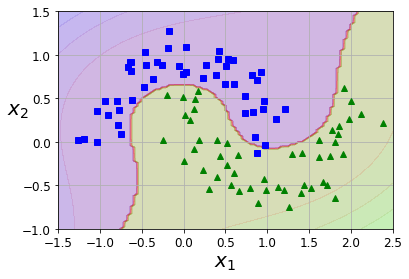

In [7]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Polynomial Kernel

In [8]:
# kernel trick
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([('scaler', StandardScaler()),
                                 ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
                                ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [9]:
# another one, now with a 10th degree polynomial kernel

poly100_kernel_svm_clf = Pipeline([("scaler", StandardScaler()),
                                   ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
                                  ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

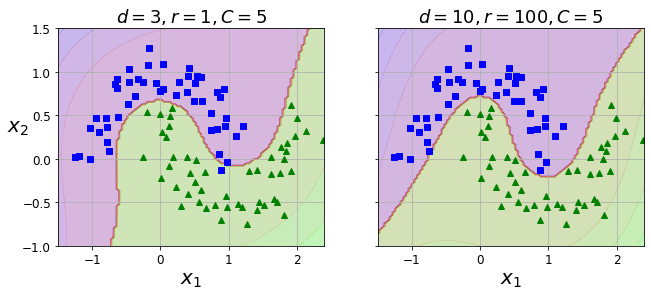

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

### Similarity Features
Technique that adds features computed using a similarity function, which measures how much each instance resembles a particular landmark.

### Gaussian RBF Kernel
It may be computationally expensive to compute all the additional features, especially on large training sets. The kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features. Let’s try the SVC class with the Gaussian RBF kernel:

In [11]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
        ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

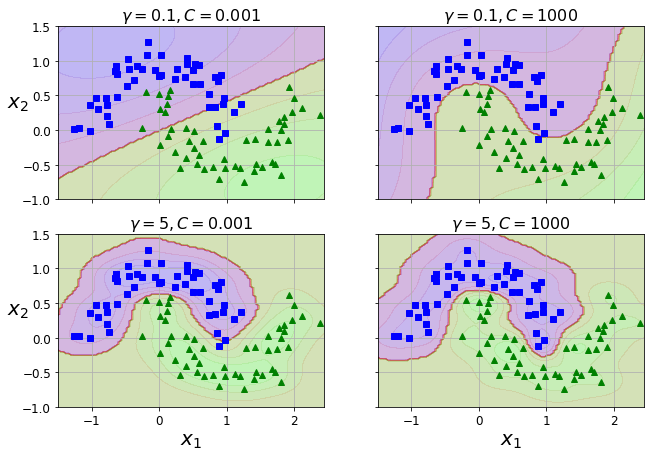

In [12]:
# training with different values of hyperparamenters gamma and C:

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

### Computational Complexity

In [13]:
df_complexity = pd.DataFrame()


# initialize list of lists 
data = [['LinearSVC', '0(m x n)', 'No', 'Yes', 'No'],
        ['SGDClassifier', '0(m x n)', 'Yes', 'Yes', 'No'],
        ['SVC', '0(m^2 x n) to 0(m^3 x n)', 'No', 'Yes', 'Yes']] 
  
# Create the pandas DataFrame 
df_complexity = pd.DataFrame(data, columns = ['Class', 
                                              'Time complexity', 
                                              'Out-of-core supportg', 
                                              'Scaling required', 
                                              'Kernel trick'])

df_complexity.style.set_properties(**{'text-align': 'left'}) # align text to the left

,Class,Time complexity,Out-of-core supportg,Scaling required,Kernel trick
0,LinearSVC,0(m x n),No,Yes,No
1,SGDClassifier,0(m x n),Yes,Yes,No
2,SVC,0(m^2 x n) to 0(m^3 x n),No,Yes,Yes


## SVM Regression

Instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, ε.